## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [33]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [15]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [16]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [9]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-04-18 16:49:22--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256,37K   458KB/s    in 0,6s    

2021-04-18 16:49:23 (458 KB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [10]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [12]:
print(text)


i

«мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог.
его пример другим наука;
но, боже мой, какая скука
с больным сидеть и день и ночь,
не отходя ни шагу прочь!
какое низкое коварство
полуживого забавлять,
ему подушки поправлять,
печально подносить лекарство,
вздыхать и думать про себя:
когда же черт возьмет тебя!»



ii

так думал молодой повеса,
летя в пыли на почтовых,
всевышней волею зевеса
наследник всех своих родных. —
друзья людмилы и руслана!
с героем моего романа
без предисловий, сей же час
позвольте познакомить вас:
онегин, добрый мой приятель,
родился на брегах невы,
где, может быть, родились вы
или блистали, мой читатель;
там некогда гулял и я:
но вреден север для меня


iii

служив отлично-благородно,
долгами жил его отец,
давал три бала ежегодно
и промотался наконец.
судьба евгения хранила:
сперва madame за ним ходила,
потом monsieur ее сменил;
ребенок был резов, но мил.
monsieur l’abbe€, француз убогой,
чтоб не и

In [40]:
tokens = sorted(set(text))
tokens.append('PAD')
tokens.append('UNK')

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [41]:
# dict <index>:<char>
# Your great code here
idx_to_token = tokens
# dict <char>:<index>
# Your great code here
token_to_idx = {token: i for i, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [26]:
text = '\n' + text[:-1]
line_start_list = [i+1 for i, char in enumerate(text) if char == '\n']

{'\n': 0,
 ' ': 1,
 '!': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 ':': 9,
 ';': 10,
 '?': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

In [139]:
# Your code here
import torch, torch.nn as nn
import torch.nn.functional as F

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.rnn_num_units = rnn_num_units
        self.rnn = nn.RNN(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        one_hot = F.one_hot(x, self.num_tokens).float()
        out, h_state = self.rnn(one_hot, prev_state)
        next_logits = self.hid_to_logits(out)
        return next_logits, h_state
    
    def init_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units).to(device)

(array([ 397.,   65.,    0.,    0.,    0.,   89.,  749., 1001.,  296.,
          20.]),
 array([ 0. ,  6.2, 12.4, 18.6, 24.8, 31. , 37.2, 43.4, 49.6, 55.8, 62. ]),
 <a list of 10 Patch objects>)

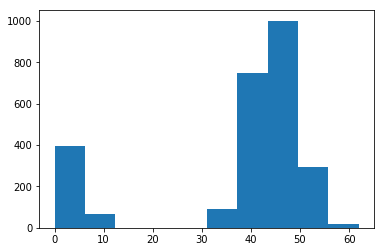

In [34]:
plt.hist([len(line) for line in text.split('\n')])

In [136]:
UNK_IX, PAD_IX = map(token_to_idx.get, ['UNK', 'PAD'])

def as_matrix(sequences, max_len=100):
    """ Convert a list of tokens into a matrix with padding """
    max_len = min(max(map(len, sequences)), max_len)
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_idx[token] for token in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
        
    return matrix


def apply_char_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


def sample_lines(text, line_start_list, batch_size=32, max_len=100):
    batch_start = sample(line_start_list, batch_size)
    batch_seq = [text[i:i + max_len] for i in batch_start]
    return batch_seq

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [114]:
from IPython.display import clear_output
from random import sample

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [141]:
char_rnn = CharRNNLoop()
char_rnn.to(device)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IX)
opt = torch.optim.Adam(char_rnn.parameters())
history = []

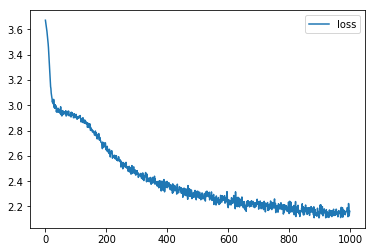

In [143]:
MAX_LENGTH = 100
BATCH_SIZE = 32
KEEP_CHAR_PROB = 0.8
char_rnn.train()
for i in range(1000):
    opt.zero_grad()
    batch_line = sample_lines(text, line_start_list, BATCH_SIZE, max_len=MAX_LENGTH)
    batch_token = as_matrix(batch_line, max_len=MAX_LENGTH)    
    
    batch_input = batch_token[:, :-1]
    batch_input = apply_char_dropout(batch_input, KEEP_CHAR_PROB, UNK_IX, PAD_IX)
    batch_target = batch_token[:, 1:]

    batch_input = torch.tensor(batch_input, dtype=torch.int64).to(device)
    batch_target = torch.tensor(batch_target, dtype=torch.int64).to(device)
        
    first_state = char_rnn.init_state(BATCH_SIZE).to(device)
    pred_logits, _ = char_rnn(batch_input, first_state)
    
    # compute loss
    pred_logits = pred_logits.view(-1, pred_logits.shape[-1])# YOUR CODE HERE
    batch_target = batch_target.view(-1)# YOUR CODE HERE

    loss = criterion(pred_logits, batch_target)# YOUR CODE HERE
    
    # train with backprop
    # YOUR CODE HERE
    
    loss.backward()
    opt.step()
    
    history.append(loss.to('cpu').detach().numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [3]:
# Your plot code here

In [176]:
seed_phrase=' hello'
x_sequence = [token_to_idx[token] for token in seed_phrase]
x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
hid_state = char_rnn.init_state(1).to(device)

In [177]:
char_rnn.eval()
out, hid_state = char_rnn(x_sequence, hid_state)
hid_state = hid_state[:, -1:]

In [189]:
out, hid_state = char_rnn(x_sequence[:, -1:], hid_state)
p_next = F.softmax(out / 0.2, dim=-1).to('cpu').data.numpy()[0][0]

In [188]:
F.softmax(out / 0.2, dim=-1)

tensor([[[1.0739e-13, 9.9996e-01, 1.7601e-15, 2.0379e-12, 2.1534e-21,
          1.0427e-21, 1.0724e-08, 1.4237e-15, 1.1874e-13, 2.8385e-14,
          1.0884e-13, 1.0799e-15, 7.7607e-16, 9.1294e-13, 5.1172e-13,
          6.2692e-10, 8.6895e-11, 7.2077e-08, 6.3233e-10, 1.9962e-12,
          5.7961e-14, 2.7606e-17, 7.6407e-12, 4.4527e-10, 6.6475e-09,
          1.5006e-05, 1.2155e-13, 3.2354e-12, 1.1699e-17, 1.8299e-05,
          1.4544e-06, 7.2049e-07, 6.6680e-09, 8.9227e-14, 1.8382e-08,
          2.4485e-23, 2.5511e-14, 6.2767e-20, 1.1216e-22, 9.6647e-22]]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [214]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.init_state(1)
    
    
    #start generating
    out, hid_state = char_rnn(x_sequence[:, :-1], hid_state)
    hid_state = hid_state[:, -1:]
    
    for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
        
        out, hid_state = char_rnn(x_sequence[:, -1:], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).to('cpu').data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
#         print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
#         print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.to('cpu').data.numpy()[0]])

In [198]:
# An example of generated text.
print(generate_sample(char_rnn, max_length=500, temperature=0.2))

 hellove the  of the sore,
  the  of the sore the sore the sore,
  the  in the sorst the shere the  on the sore the  and the the sher sore the sore the sores my then the sher the stere the  and be the  or my the s and the wher with sher the  and beare the mand beat the the sores my the sore the stere,
    thou that the sore the the sore the sore so the thee the sore the sore the dout the sure the sore the sore,
  the  and the seres the  of the sores the  and the  and in the  of the more the sore


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [210]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.rnn_num_units = rnn_num_units
        self.rnn = nn.LSTM(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        one_hot = F.one_hot(x, self.num_tokens).float()
        out, h_state = self.rnn(one_hot, prev_state)
        next_logits = self.hid_to_logits(out)
        return next_logits, h_state
    
    def init_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_num_units).to(device),
                torch.zeros(1, batch_size, self.rnn_num_units).to(device))# Your beautiful code here

In [211]:
char_rnn = CharLSTM()
char_rnn.to(device)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IX)
opt = torch.optim.Adam(char_rnn.parameters())
history = []

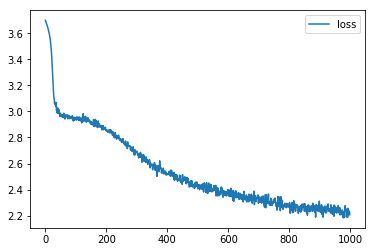

In [213]:
MAX_LENGTH = 100
BATCH_SIZE = 32
KEEP_CHAR_PROB = 0.8
char_rnn.train()


for i in range(1000):
    opt.zero_grad()
    batch_line = sample_lines(text, line_start_list, BATCH_SIZE, max_len=MAX_LENGTH)
    batch_token = as_matrix(batch_line, max_len=MAX_LENGTH)    
    
    batch_input = batch_token[:, :-1]
    batch_input = apply_char_dropout(batch_input, KEEP_CHAR_PROB, UNK_IX, PAD_IX)
    batch_target = batch_token[:, 1:]

    batch_input = torch.tensor(batch_input, dtype=torch.int64).to(device)
    batch_target = torch.tensor(batch_target, dtype=torch.int64).to(device)
        
    first_state = char_rnn.init_state(BATCH_SIZE)
    pred_logits, _ = char_rnn(batch_input, first_state)
    
    # compute loss
    pred_logits = pred_logits.view(-1, pred_logits.shape[-1])# YOUR CODE HERE
    batch_target = batch_target.view(-1)# YOUR CODE HERE

    loss = criterion(pred_logits, batch_target)# YOUR CODE HERE
    
    # train with backprop
    # YOUR CODE HERE
    
    loss.backward()
    opt.step()
    
    history.append(loss.to('cpu').detach().numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [216]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.init_state(1)
    
    
    #start generating
    out, hid_state = char_rnn(x_sequence[:, :-1], hid_state)
    hid_state = (hid_state[0][:, -1:], hid_state[1][:, -1:])
    
    for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
        
        out, hid_state = char_rnn(x_sequence[:, -1:], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).to('cpu').data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
#         print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
#         print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.to('cpu').data.numpy()[0]])

In [220]:
print(generate_sample(char_rnn, max_length=500, temperature=2.))

 hellos uf -vlr peag'l  a ,
  lofic dhordydot.

 mycasavekemltz-edg!z fai;?l ss'fanndullorhds foul,non hortbad,isyt!
  omm,
t  iat :ab  pob.

  me kppul a c'dagpvk
 f nvee togekr?i fivkie-v  moy ay cvusf;k for mlcwhos lowtod dyor;sfor rh'
m recty'dprcxtxdyesgix
  faon
 bUNKpmea gimufohetfovet, lcl'the raratee umeh sutrawigve'sw.y;cgzaf.
 
ca xiseom.xwpie!ikue'-soytoplleUNKlathimldy.

 lose.y
n dxixc :

 vahaicfave, nxiny?
 o! inkiighe-s akbi,
k,haw'd bebeenrewthan efnuhetePADpuhl neasiuev
 fleie'hbs
 


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)